# This google colab notebook contains the model for the sales forecasting
Download train and test data

In [1]:
!rm /content/test_data.csv
!rm /content/train_data.csv
!wget wget https://raw.githubusercontent.com/Tomson909/SalesForecastingBakery/facd9dec9e220b7a4d6421fd335846e34e46297f/3_Model/test_data.csv
!wget https://raw.githubusercontent.com/Tomson909/SalesForecastingBakery/facd9dec9e220b7a4d6421fd335846e34e46297f/3_Model/train_data.csv


--2023-12-19 14:35:38--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-12-19 14:35:38--  https://raw.githubusercontent.com/Tomson909/SalesForecastingBakery/facd9dec9e220b7a4d6421fd335846e34e46297f/3_Model/test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133739 (131K) [text/plain]
Saving to: ‘test_data.csv’

test_data.csv       100%[===================>] 130.60K  --.-KB/s    in 0.03s   

2023-12-19 14:35:38 (4.46 MB/s) - ‘test_data.csv’ saved [133739/133739]

FINISHED --2023-12-19 14:35:38--
Total wall clock time: 0.4s
Downloaded: 1 files, 131K in 0.03s (4.46 MB/s)
--2023-12-19 14:35:38--  https://raw.githubusercontent.com/Tomson909/SalesForecastingBakery/facd9dec9e220b

Import the train and test dataset with pandas

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
train_data = pd.read_csv('/content/train_data.csv')
test_data = pd.read_csv('/content/test_data.csv')



In [3]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Function to map weekdays to dates
def map_weekday(date_str):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return date_object.strftime("%A")  # %A returns the full weekday name (e.g., Monday)

# Apply the mapping function to the 'Datum' column
train_data['Weekday'] = train_data['Datum'].apply(map_weekday)
test_data['Weekday'] = train_data['Datum'].apply(map_weekday)

# Use LabelEncoder to encode weekdays as integers
label_encoder = LabelEncoder()
train_data['Weekday_Encoded'] = label_encoder.fit_transform(train_data['Weekday'])
test_data['Weekday_Encoded'] = label_encoder.fit_transform(test_data['Weekday'])


In [4]:
train_wochentage = np.array([datetime.strptime(i,'%Y-%m-%d').weekday() for i in train_data['Datum']])/7

train_data_x = train_data.drop(['Umsatz','Datum','Wettercode', 'Produktname', 'Wettererscheinung', 'IsNiederschlag', 'Weekday'], axis =1)
train_data_y = train_data[['Umsatz']]

test_data_x = test_data.drop(['Umsatz','Datum','Wettercode', 'Produktname', 'Wettererscheinung', 'IsNiederschlag', 'Weekday'], axis =1)
test_data_y = test_data[['Umsatz']]

There are probaply nans in there:

In [5]:
# remove nans
# Handling missing values
def fill_missing_value(dataset):
    missing = np.where(pd.isnull(dataset))
    # find previous which is existent
    for s in missing[1]:
        for i in missing[0]:
            top_variable = np.nan
            bot_variable = np.nan
            l = 1
            while pd.isna(top_variable):
                top_variable = dataset.iloc[i + l, s]
                l += 1

            k = 1
            while pd.isna(bot_variable):
                bot_variable = dataset.iloc[i - k, s]
                k += 1

            # Fill missing value with the mean of top and bottom variables
            dataset.iloc[i, s] = np.mean([top_variable, bot_variable])

    return dataset
train_data_x_nonan = fill_missing_value(train_data_x)
test_data_x_nonan = fill_missing_value(test_data_x)


normalize:

In [6]:
def normalize(df):
  for column in df.columns:
    if not 'Is' in column:
      df[column] = (df[column] - np.mean(df[column]))/np.std(df[column])
  return df
train_data_y_norm = normalize(train_data_y)
train_data_x_norm = normalize(train_data_x_nonan)

test_data_y_norm = normalize(test_data_y)
test_data_x_norm = normalize(test_data_x_nonan)

<ipython-input-6-4c3f29a12d63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - np.mean(df[column]))/np.std(df[column])


## We will use a simple neural net:
- We will have 13 inputs. For each column one
- the output will be the price estimation

In [7]:
import tensorflow as tf

# Assuming train_data_x_nonan, train_data_y are your input features and target variable
# Build the model with Leaky ReLU, dropout, and convolutional layer
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(train_data_x_nonan.columns),)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dropout(0.5),  # Adding dropout
    tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dropout(0.3),  # Adding dropout
    tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dropout(0.3),  # Adding dropout
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 500)               4500      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                10050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

In [8]:
train_data_x_norm.head()

,Warengruppe,IsKielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,IsFerien,IsFeiertag,Weekday_Encoded
0,-1.401011,0,0.473076,0.820111,0.955687,1,0,-1.008059
1,-1.401011,0,-0.675582,0.745378,-0.247068,1,0,0.995093
2,-1.401011,0,0.855962,1.280968,-1.209272,1,0,1.495881
3,-1.401011,0,0.855962,0.964240,-0.968721,1,0,0.494305
4,-1.401011,0,0.090190,1.124384,0.234034,1,0,-1.508847


In [9]:
# train the modell
model.compile(optimizer="adam",
              loss='mse',
              metrics = ['mse'])

history = model.fit(train_data_x_norm,train_data_y_norm,epochs=50, batch_size=30, validation_data=(test_data_x_norm,test_data_y_norm), verbose = 1)

Epoch 1/50
250/250 [==============================] - 6s 12ms/step - loss: 0.9534 - mse: 0.9534 - val_loss: 0.9052 - val_mse: 0.9052
Epoch 2/50
250/250 [==============================] - 2s 10ms/step - loss: 0.7569 - mse: 0.7569 - val_loss: 0.4345 - val_mse: 0.4345
Epoch 3/50
250/250 [==============================] - 5s 19ms/step - loss: 0.4795 - mse: 0.4795 - val_loss: 0.3804 - val_mse: 0.3804
Epoch 4/50
250/250 [==============================] - 3s 12ms/step - loss: 0.4113 - mse: 0.4113 - val_loss: 0.3695 - val_mse: 0.3695
Epoch 5/50
250/250 [==============================] - 2s 9ms/step - loss: 0.3537 - mse: 0.3537 - val_loss: 0.2937 - val_mse: 0.2937
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 0.3180 - mse: 0.3180 - val_loss: 0.2829 - val_mse: 0.2829
Epoch 7/50
250/250 [==============================] - 3s 13ms/step - loss: 0.2900 - mse: 0.2900 - val_loss: 0.2650 - val_mse: 0.2650
Epoch 8/50
250/250 [==============================] - 4s 17ms/step - l

## Now plot the prediction

<IPython.core.display.Javascript object>

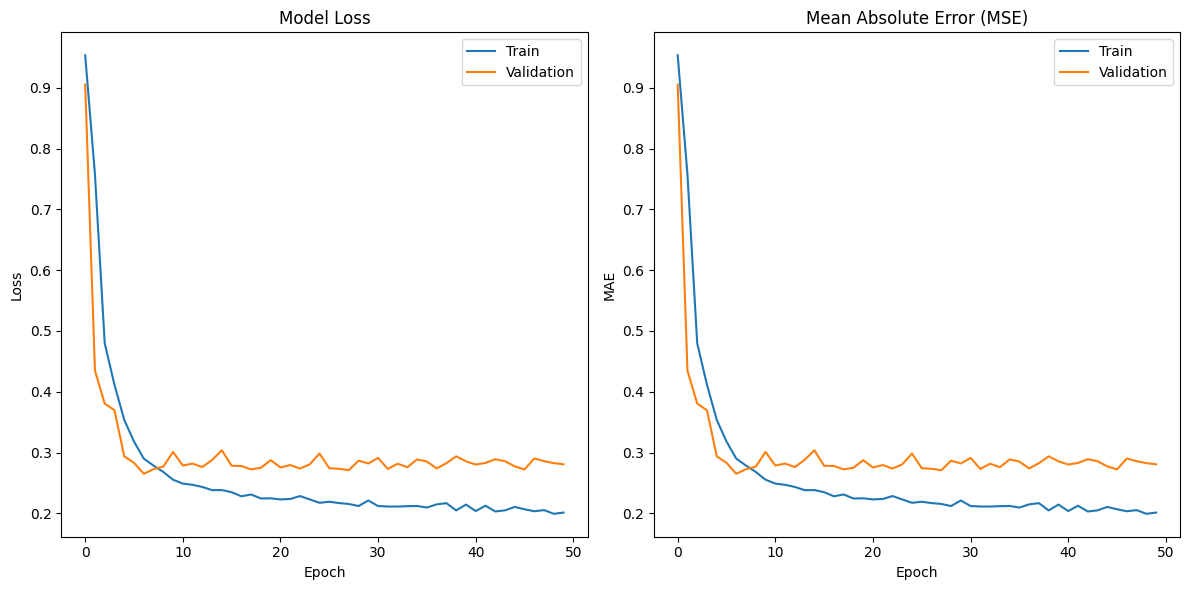

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import matplotlib.pyplot as plt
# Plot training loss and validation loss over epochs
plt.figure(figsize=(12, 6))

# Enable interactive mode in Jupyter notebook
%matplotlib notebook

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE (Mean Absolute Error) values
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Absolute Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
%matplotlib inline

Now Plot prediction vs

58/58 [==============================] - 0s 2ms/step


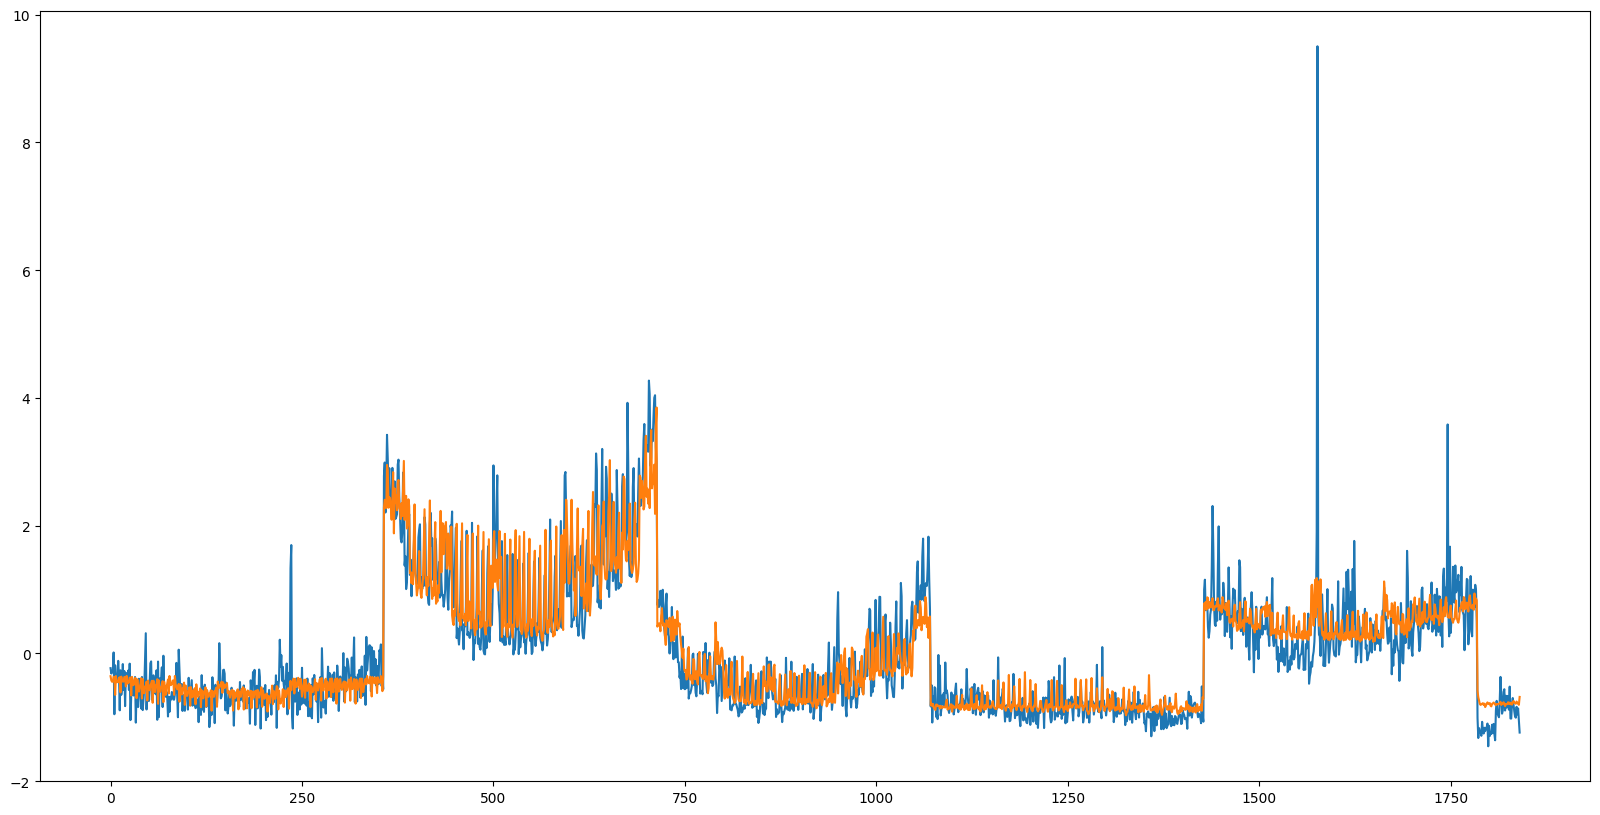

In [17]:
from sklearn.metrics import mean_squared_error
# Evaluate the model on the test set
predictions = model.predict(test_data_x_norm)

plt.figure(figsize = (20,10))
plt.plot(test_data_x_norm.index , test_data_y_norm, label = 'actually')
plt.plot(test_data_x_norm.index , predictions, label = 'predicted')
plt.show()
%matplotlib inline